In [1]:
import vsms
from vsms import estimation, evaluation_tools, sampler_utils, bench_utils

import importlib


## sampler common
## sampler utils
## bench utils
## estimation 
## evaluation tools
## plotting
## avutils

# importlib.reload(vsms)
# importlib.reload(vsms.sampler_common)
# importlib.reload(vsms.sampler_utils)
# importlib.reload(vsms.bench_utils)
# importlib.reload(vsms.estimation)
# importlib.reload(vsms.evaluation_tools)
# importlib.reload(vsms.coco_categories)

import matplotlib
#importlib.reload(matplotlib.pyplot)
from matplotlib import pyplot as plt
from vsms.plotting import *
from vsms.estimation import *
from vsms.bench_utils import *
from vsms.sampler_utils import *
from vsms.evaluation_tools import *
from vsms.sampler_common import *
from vsms.avutils import *
#import vsms.coco_categories as cc
import matplotlib as mpl
import matplotlib.pyplot as plt

import sys
p = '/nvme_drive/orm/car_stuff/deployment/blazeit'
if p not in sys.path:
    sys.path.append(p)
    
import blazeit
import blazeit.specializers.trn as trn
%matplotlib notebook

ImportError: cannot import name 'estimation' from 'vsms' (/nvme_drive/orm/vls/vsms/__init__.py)

In [2]:
import pandas.api.types as pdtypes
from plotnine import (ggplot, geom_point, geom_bar, geom_boxplot, 
                      geom_col, aes, stat_smooth, position_dodge,
                    facet_wrap, facet_grid, stats, geom_text, stat_quantile, 
                      geom_segment, scale_x_discrete, scale_y_continuous, annotate, 
                      geom_jitter, geom_hline, geom_errorbar, scale_y_reverse)
from plotnine.data import mtcars
from plotnine.scales import scale_y_log10
from plotnine import theme, xlab, labs, element_text, scale_y_continuous

In [3]:
import torchvision.models as models
import torchvision

In [4]:
ds_dash = Dataset(data_root='/nvme_drive/orm/results10/', dataset_name='dashcam_unified_ng')
#ds_square = Dataset(data_root='/nvme_drive/orm/results10/', dataset_name='jackson-town-square')

In [5]:
ds = ds_dash

In [ ]:
ds.ma

In [6]:
class UniqueScore(ScoringModel):
    def __init__(self, **base_args):
        super().__init__(**base_args)
        
    def update(self):
        pass

    def score(self, batch_size):
        assert self.randomize
        ds = dist.Gamma(concentration=self.stats.Nunique + .1, rate=self.stats.Ns + 1.) 
        s =  ds.sample(batch_size)
        return s 
    
class GtScore(ScoringModel):
    def __init__(self, **base_args):
        super().__init__(**base_args)
        
    def update(self):
        pass

    def score(self, batch_size):
        assert self.randomize
        ds = dist.Gamma(concentration=self.stats.Nonce + .1, rate=self.stats.Ns + 1.) 
        s =  ds.sample(batch_size)
        return s

In [7]:
def random_plus(size=None, scores=None, initial_step=256, initial_offset=None):
    if size is None:
        size = scores.shape[0]

    if scores is None:
        scores = np.random.normal(size=size)
    if isinstance(scores, pd.Series):
        scores = scores.values

    x = np.arange(size)
    assert scores.shape[0] == size

    if initial_step > size//4:
        initial_step = size//4
        
    if initial_offset is None:
        initial_offset = np.random.randint(initial_step)    
    
    acc_idxs = []
    step = initial_step
    offset = initial_offset
    seen = pr.BitMap()
    while step >= 1:
        offset = offset % step

        assert offset < step
        tmp = x[offset::step]
        new_set = pr.BitMap(tmp).difference(seen)#.to_array() # remove duplicates
        next_idxs = np.array(new_set)
        score_order = np.argsort(scores[next_idxs])[-1::-1] # descending order
        next_idxs = next_idxs[score_order]
        acc_idxs.append(next_idxs)
        seen = seen.union(new_set)

        step = step//2

    out = np.concatenate(acc_idxs)
    assert np.unique(out).shape[0] == out.shape[0]
    assert out.shape[0] == x.shape[0]
    return out

In [8]:
def score_minus(sc, ds, 
                object_class, 
                excluded_frames, 
                initial_distance=32):

    scores = sc[object_class]
    hits = ds.boxes.loc[COCO_IDS[object_class]].index
    assert (sc.index == pd.RangeIndex(ds.video.len)).all(), 'work with absolute index'

    excluded = pr.FrozenBitMap(excluded_frames)
    all_frames = pr.FrozenBitMap(sc.index)
    assert excluded.issubset(all_frames)
    
    acc  = []
    seen = pr.FrozenBitMap([])
    dist = initial_distance
    while len(seen) < len(all_frames - excluded):
        locs = score_minus_helper(scores, hits, 
                                  initial_ex=excluded.union(seen), 
                                  distance=dist)
        dist = dist//2
        seen = seen.union(pr.FrozenBitMap(locs))
        acc.append(locs)
    
    final = np.concatenate(acc)
    assert len(pr.BitMap(final)) == final.shape[0] # no repeats
    assert pr.BitMap(final).intersection_cardinality(excluded) == 0 # no training set
    assert final.shape[0] == len(all_frames) - len(excluded) # all remaining
    return pd.Index(final, name='blz_'+ object_class)
    

def score_minus_helper(scores, hits, initial_ex=None, distance=32):
    banned = pr.BitMap(initial_ex)
    
    start_locs = pr.BitMap(scores.index).difference(banned)    
    scores = scores.loc[start_locs]
    locs = scores.sort_values(ascending=False).index
    hits = pr.BitMap(hits)
    output_locs = []
    for l in locs:
        if l in banned:
            continue 
        else:
            output_locs.append(l)
#            if l in hits: # only clear range for positive result
            banned.add_range(l-distance,l+distance)
                
    return np.array(output_locs)

In [10]:
# ds = ds_square
# #frame_meta = pd.read_parquet('/nvme_drive/orm/dashcam_frame_metadata_v2.parquet')
# #frame_meta = pd.read_parquet('/nvme_drive/orm/dashcam_frame_metadata_v2.parquet')
# frame_meta = pd.DataFrame({'frame_ts':ds.max_scores.index, 
#                             'trip_id':pd.Categorical(ds.max_scores.index.round('H')).codes})

In [9]:
if True:
    blazed_logits2 = pd.read_parquet('/nvme_drive/orm/dashcam_logits_balanced.parquet')
else:
    blazed_logits2 = pd.read_parquet('/nvme_drive/orm/square_logits_balanced.parquet')

obj_cols = [c for c in blazed_logits2.columns if c in COCO_CATEGORIES]
bl = blazed_logits2[obj_cols]
bl_rest = bl[blazed_logits2.subset == 'rest']
training_set = bl[blazed_logits2.subset.isin(['train', 'val'])].index

In [15]:
## how to proceed.
## assumptions thus far: extract top 10 pca based on some sample of data.
## experiments: log reg for traffic light is still much better than random (3x more AP), so assume predictive power.

## design0: blaze it w. light scan: train on all features. then, scan all saved features (vs scan all video)
## design1: frames pre-sorted by those 10 main features, pick the single one with most predictive power. use that.

## design2: using features + exsample. 
    ## design2.0: sample using transformed feature values as weights.
            ## pick best feature.

    ## design2.1: cluster features, use those as buckets.
    ## design2.2: use time buckets. sample using transformed feature values.

(1164206, 10)

In [10]:
bl3 = pd.read_parquet('scores_best_dim.parquet')

In [12]:
blazed_logits2.index.shape, bl3.index.shape

((1164226,), (1164206,))

In [13]:
bl3 = pd.concat([bl3, bl3.iloc[np.random.randint(low=0, high=bl3.shape[0], size=20)]], ignore_index=True)

In [14]:
bl3_rest = bl3[blazed_logits2.subset == 'rest']

In [15]:
class Bench2(object):
    ## meant to keep track of previous runs so we don't lose them
    def __init__(self, ds, excluded_set=[]):
        self.params = []
        self.param_names = []
        self.graders = []
        self.samplers = []
        self.excluded_set = pr.FrozenBitMap(excluded_set)
        dsfr = ds.boxes.reset_index()
        self.ok_boxes = dsfr[~dsfr.frame_idx.isin(self.excluded_set)]
        (self.NIs, self.NF) = get_NI_NF(ds, self.excluded_set)

        gfs = {}
        for (l,gp) in self.ok_boxes.groupby(['label']):
            label = COCO_CATEGORIES[l]
            tidcodes = pd.Categorical(gp.tid).codes
            tids = pd.Series(tidcodes, index=gp.frame_idx)
            gf = GraderMFactory(tids, NF=self.NF, excluded_set=self.excluded_set)
            gfs[label] = gf

        self.grader_factories = gfs
#         random_offset_ts = (ds.frame_timestamps.round('1 ms')
#                             + pd.to_timedelta(np.random.randint(9999999), unit='ms'))
#         lsb_values = time_series_to_lsb(random_offset_ts)

#         # common splits
        self.nosplit = pd.Series(np.ones(ds.video.len), name='nosplit')
#         self.split10min = time_split2(ds.max_scores, '10 min')
#         self.split20min = time_split2(ds.max_scores, '20 min')
#         self.split30min = time_split2(ds.max_scores, '30 min')
#         self.split1hr = time_split2(ds.max_scores, '60 min')
#         self.split5min = time_split2(ds.max_scores, '5 min')
        self.object_classes = list(gfs.keys())
        # common order
#         self.lsb_ilocs = lsb_values.reset_index(drop=True).sort_values().index.rename('lsb')
#         self.random_ilocs = pd.Int64Index(np.random.permutation(ds.frame_timestamps.shape[0]), name='random')
#         self.skip_1s_ilocs = ds.max_scores.assign(sec=random_offset_ts.floor('1s')).reset_index().drop_duplicates(
#             subset=['sec'], keep='first').index.rename('skip_1s')

In [16]:
def remove_in(seq, bad_set):
    return seq[seq.map(lambda i : i not in bad_set)]    

In [195]:
# 1) explain problems with balanced dataset : very common or very rare.
# 2) explain problems with dataset drift as shown by plot
# 3) explain initial fixed cost issue.


# converting a set of scores to a sampling strategy/
# explain.
# 3) why is truck performance not great. 

In [ ]:
## weighted sampling alone

In [17]:
import scipy.stats

In [18]:
from scipy.special import expit, logit, softmax

In [19]:
special_score = pd.read_parquet('rep_loss_no_flow_tr.parquet')

In [180]:
# for c in special_score.columns:
#     special_order = np.random.choice(a=bl_rest.index, size=bl_rest.shape[0], replace=False, p=softmax(sp_rest['traffic light'].values))
#     special_order = pd.Index(special_order, name='OptNew')

In [186]:
# sp_strict = sp_rest.sort_values(['traffic light'], ascending=False)

In [21]:
# ilocs = pd.Index(sp_strict.index, name='SpStrict')
b4 = Bench2(ds, excluded_set=training_set)
batch_size= 50

In [24]:
#   noised_pkt_size = sm_pkt_size2*np.random.gamma(32.,scale=1./32, size=sm_pkt_size.shape[0])
#   pkt_size_ilocs = noised_pkt_size.sort_values().index.rename('pkt_size')
#   new_order = np.random.permutation(frame_meta.trip_id.max()+1)
#   part_order = new_order[frame_meta.trip_id][pkt_size_ilocs]
#   skip_1s_ilocs = pd.DataFrame({'skip1s':b4.skip_1s_ilocs, 'part_order':part_order}).sort_values(['part_order', 'skip1s']).skip1s.rename('skip_1s')
#   pkt_size_ilocs = pd.DataFrame({'skip1s':b4.skip_1s_ilocs, 'part_order':part_order}).sort_values(['part_order', 'skip1s']).skip1s.rename('skip_1s')
# bl = bl3
# bl_rest = bl3_rest
for col in special_score.columns:
#     ps = bl_rest[col]
#     logits = logit(ps)
#     orders = []
#     for temp in (1,.01, .1, 10, 100, 1000):
#         ps = softmax(logits/temp)
#         tmp1 = pd.Index(np.random.choice(a=bl_rest.index, size=bl_rest.shape[0], replace=False, p=ps), 
#                         name='temp_{}'.format(temp))
#         orders.append(tmp1)
# #         np.random.choice(a=bl_rest.index, size=bl_rest.shape[0], replace=False, p=ps)
    sp_minus = score_minus(special_score, ds_dash, col, training_set).rename('SpLossNoFlow')    
    
    sampler_combx = named_prod(order=[sp_minus], 
                      score_method=[None],
                      damping=[None],
                      split=[b4.nosplit],
                        batch_size=[batch_size],
                        object_class=[col])
    add_combos2(b4, sampler_combx)

    
#rplus = remove_in(pd.Series(random_plus(size=bl.shape[0])).rename('rplus'), training_set)
# # r = remove_in(pd.Series(np.random.permutation(bl.shape[0])).rename('random'), training_set)
# sampler_comb = named_prod(order=[rplus], 
#                       score_method=[None],
#                       damping=[None],
#                       split=[b4.nosplit],
#                         batch_size=[batch_size],
#                         object_class=b4.object_classes[:3])

# add_combos2(b4, sampler_comb)

# sampler_comb3 = named_prod(order=[rplus], 
#                        score_method=[GtScore], 
#                        damping=[None],
#                        split=[b4.split30min],
#                          batch_size=[batch_size],
#                          object_class=b4.object_classes[:3])

# add_combos2(b4, sampler_comb3)

In [25]:
run_up_to2(b4, recall_threshold=.9, sample_threshold=1000000)

In [26]:
res13 = get_results(b4).assign(dataset='dashcam', method='SpNoFlow')

In [58]:
#res10 = res10.assign(method=res10.method.map(lambda x: 'bestdim0' if x.startswith('NN_desc0') else 'LRbestdim'))

In [161]:
#avd = VideoDataset('/nvme_drive/orm/results10/videos/dashcam_unified_ng_kf20_full.mp4')

In [111]:
#res10f = res10[res10.method == 'LRbestdim'].assign(dataset='dashcam')

In [27]:
#bar_data = pd.concat([res10f, bar_data], sort=True)
plot_results(pd.concat([bar_data[bar_data.method.isin('random')],res13]), max_frame_f=.05).interactive()
#bar_data = bar_data[0]

NameError: name 'bar_data' is not defined

In [40]:
import scipy.stats
def savings_at(all_res, ni=None, instance_f=None, agg=scipy.stats.gmean, rel=None, agg_min=5, compare='nf'):
    all_res = all_res.sort_values(['dataset', 'object_class', 'method', 'nf', 'ni'])
    all_methods = all_res.method.unique()

    if ni is not None:
        pred = all_res.ni >= ni
    elif instance_f is not None:
        pred = all_res.instance_f >= instance_f
    else:
        assert False

    fst = all_res[pred].groupby(['dataset', 'object_class', 'method', 'sampler_id'])[compare].min().reset_index()
    
    if rel is not None:    
        res_rel = fst[fst.method == rel]
        baselines = res_rel.groupby(['dataset','object_class'])[compare].median().rename('baseline')    
        fst_wbase = pd.merge(fst, baselines, how='left', left_on=['dataset','object_class'], right_index=True)
        fst_wbase['savings'] = fst_wbase['baseline']/fst_wbase[compare]
        compare = 'savings'

    if agg is not None:
        gp = fst.groupby(['dataset', 'object_class', 'method'])[compare]
        gmeans = gp.agg(agg).unstack('method')
        tot= gp.size().unstack('method')

        if rel is not None:
            gm = gmeans.apply(lambda x: old_div(gmeans[rel], x))
            #gm[rel] = gmeans[rel]
        else:
            gm = gmeans

        #order = ['video_bandit', 'gt_bandit', 'lsb', '1fps','random', 'noscope(inf)']
        for m in all_methods:
            if m not in gm.columns:
                gm[m] = -np.inf

        #order = [o for o in order if o in gm.columns]
        return gm[tot >= agg_min].style.format('{:.1f}').background_gradient(axis=1)
    else:
        return fst_wbase

In [374]:
#res5.assign(dataset='dashcam').to_parquet('/nvme_drive/orm/sigmod_eval_sec2_v3_single_run.parquet')

In [35]:
# new_dash = pd.read_parquet('/nvme_drive/orm/sigmod_eval_sec2_v3_single_run.parquet')
# new_square = pd.read_parquet('/nvme_drive/orm/sigmod_eval_sec2_v3_square_single_run.parquet')

#res_now3 = pd.read_parquet('/nvme_drive/orm/sigmod_eval_sec2_v2.parquet')

In [138]:
#prev_ok = res_now[res_now.object_class != 'parking meter']

In [146]:
#res_now = pd.concat([prev_ok, res5], sort=False)

In [44]:
res12 = res12.assign(method='SpLoss')

In [28]:
res_now = pd.read_parquet('/nvme_drive/orm/sigmod_eval_res_checkpoint.parquet')
bar_data = res_now
#bar_data  = pd.concat([res12, bar_data], sort=True)

In [29]:
bar_data.method.unique()

array(['blz0', 'blz1', 'blz2', 'random+', 'random', 'this_work',
       'this work', 'unique', 'NN_desc', 'NN', 'NN+', 'NN score'],
      dtype=object)

In [30]:
def rnfn(k):
    d = {'this_work':'this work',
         'NN_desc':'NN score',
        'blz0':'NN score',
        'blz1':'BlazeIt',
         'NN':'BlazeIt',
        'blz2':'NN+',
        'NN_score': 'NN score'}

    return d[k] if k in d else k

#median_savings = cdat[['dataset','recall','method','object_class','savings', 'metric']]
#ms = median_savings
bar_data = bar_data.assign(method=bar_data.method.map(rnfn))
#bar_data = bar_data.assign(method=bar_data.method.map(rnfn))

In [32]:
#bar_data.method.isin(['LRbestdim']).any()

In [33]:
bar_data = bar_data[bar_data.method.isin(['BlazeIt','this work','random+','random', 'LRbestdim', 'SpLoss'])]
bar_data = bar_data[bar_data.object_class != 'parking meter']
bar_data = bar_data[bar_data.dataset == 'dashcam']

In [34]:
bar_data.method.unique()

array(['BlazeIt', 'random+', 'random', 'this work'], dtype=object)

In [35]:
ests = pd.read_parquet('time_estimates_101_2.parquet')
def merge_ests(bar_data, ests):
    throughputs = ests[ests.phase == 'sample'].set_index(['dataset','phase']).xput.unstack(level=1)
    fixed_costs = ests[ests.phase != 'sample'].set_index(['dataset','phase']).est_seconds.unstack(level=1)
    costs = fixed_costs.assign(sample_xput=throughputs['sample'])
    bmerge = pd.merge(bar_data, costs, left_on=['dataset'], right_index=True)
    
    bmerge = bmerge.assign(overhead=(bmerge.score + bmerge.train + bmerge.label)*bmerge.method.isin(['BlazeIt']),
             sample_time=(bmerge.nf/bmerge.sample_xput))
    bmerge = bmerge.assign(total_time=bmerge.overhead +  bmerge.sample_time)
    return bmerge

In [36]:
bmerge = merge_ests(bar_data, ests)

In [37]:
def recall_cdat(bmerge):
    dat = []
    for insf in list([.1, .5, .9]):
        tmp2 = savings_at(bmerge, instance_f=insf, agg=None, compare='total_time', rel='random+')
        tmp3 = tmp2.assign(recall=insf)
        dat.append(tmp3)

    cdat = pd.concat(dat).assign(metric='time savings')


    dat = []
    for insf in list([.1, .5, .9]):
        tmp2 = savings_at(bmerge, instance_f=insf, agg=None, compare='nf', rel='random+')
        tmp3 = tmp2.assign(recall=insf)
        dat.append(tmp3)

    cdat2 = pd.concat(dat).assign(metric='savings in frames')
    return pd.concat([cdat, cdat2], sort=True)
    
def count_cdat(bmerge):
    dat = []
    ls = [5,10,50]
    for insf in list(ls):
        tmp2 = savings_at(bmerge, ni=insf, agg=None, compare='total_time', rel='random+')
        tmp3 = tmp2.assign(recall=insf)
        dat.append(tmp3)

    cdat = pd.concat(dat).assign(metric='elapsed time')


    dat = []
    for insf in list(ls):
        tmp2 = savings_at(bmerge, ni=insf, agg=None, rel='random+')
        tmp3 = tmp2.assign(recall=insf)
        dat.append(tmp3)

    cdat2 = pd.concat(dat).assign(metric='frames processed')
    return pd.concat([cdat, cdat2], sort=True)


def cleanup(cdat):
    from scipy.stats  import gmean

    def rnfn(k):
        d = {'this_work':'this work',
             'NN_desc':'NN score',
            'blz0':'NN score',
            'blz1':'BlazeIt',
             'NN':'BlazeIt',
            'blz2':'NN+',
            'NN_score': 'NN score'}

        return d[k] if k in d else k

    median_savings = cdat[['dataset','recall','method','object_class','savings', 'metric']]
    ms = median_savings
    ms = ms.assign(method=ms.method.map(rnfn))
    ms = ms[ms.method.isin(['this work', 
                            #'NN score',
                            'LRbestdim',
                            'random', 
                            'BlazeIt',
                            'SpLoss'
                           ])]
    ms = (ms.groupby(['dataset', 'recall', 'method', 'object_class', 'metric'])
            .savings.agg(q2=lambda a : scipy.quantile(a, q=.2),
                        q8=lambda a : scipy.quantile(a, q=.8),
                      q5=lambda a : scipy.quantile(a, q=.5))
         ).reset_index()

    gmn = (ms.groupby(['dataset', 'method', 'recall', 'metric'])
           .q5.agg(gmean).reset_index().assign(object_class='geomean')
          )

    gms = pd.concat([ms, gmn], sort=True) #median_savings.assign(object_class=short_class)

    oc =  (gms.groupby(['dataset', 'method', 'object_class', 'metric'])
            .q5.agg(gmean).reset_index().assign(recall='geomean'))
    oc = oc.assign(is_geomean=(oc.object_class=='geomean'))
    order_by_savings = oc[oc.method.isin(['this work']) & 
                         (oc.metric == 'savings in frames')].sort_values(['dataset','is_geomean','q5'], ascending=False)
    do_order_type = pd.CategoricalDtype(order_by_savings[['dataset', 'object_class']].apply(tuple, axis=1).values)
    ok = pd.Categorical(gms[['dataset','object_class']].apply(tuple,axis=1), dtype=do_order_type)
    gms = gms.assign(order_key=ok)
    return gms

In [38]:
bmerge.method.unique()

array(['BlazeIt', 'random+', 'random', 'this work'], dtype=object)

In [41]:
cdat = recall_cdat(bmerge)

In [42]:
gms = cleanup(cdat)

In [43]:
gms.method.unique()

array(['BlazeIt', 'random', 'this work'], dtype=object)

In [44]:
frms = gms[gms.metric == 'savings in frames']

In [45]:
times = gms[gms.metric == 'time savings']

In [46]:
sidebyside = times.groupby(['object_class', 'recall', 'method']).q5.max().unstack(level=2).reset_index()

In [47]:
sbs = sidebyside.assign(ratio=sidebyside['this work']/sidebyside['BlazeIt'])

In [48]:
obs_only=sbs[sbs.object_class != 'geomean']

In [55]:
gmean_only=sbs[sbs.object_class == 'geomean']

In [49]:
x = (obs_only.set_index(['recall', 'object_class'])[['this work', 'ratio']]
.rename({'this work':'vs random', 'ratio':'vs BlazeIt'}, axis=1)).unstack(0)
x.style.highlight_max()

In [51]:
from scipy.stats import gmean

In [52]:
obs_only[['this work','ratio']].apply(gmean,axis=0)

method
this work     2.366442
ratio        22.015122
dtype: float64

In [53]:
 x.apply(gmean, axis=0)

method      recall
vs random   0.1         2.845914
            0.5         2.449571
            0.9         1.900971
vs BlazeIt  0.1       177.026424
            0.5        15.305327
            0.9         3.938062
dtype: float64

In [56]:
gmean_only.set_index('recall')[['this work', 'ratio']].rename({'this work':'vs random', 'ratio':'vs BlazeIt'}, axis=1).apply(gmean)

method
vs random      2.366442
vs BlazeIt    22.015122
dtype: float64

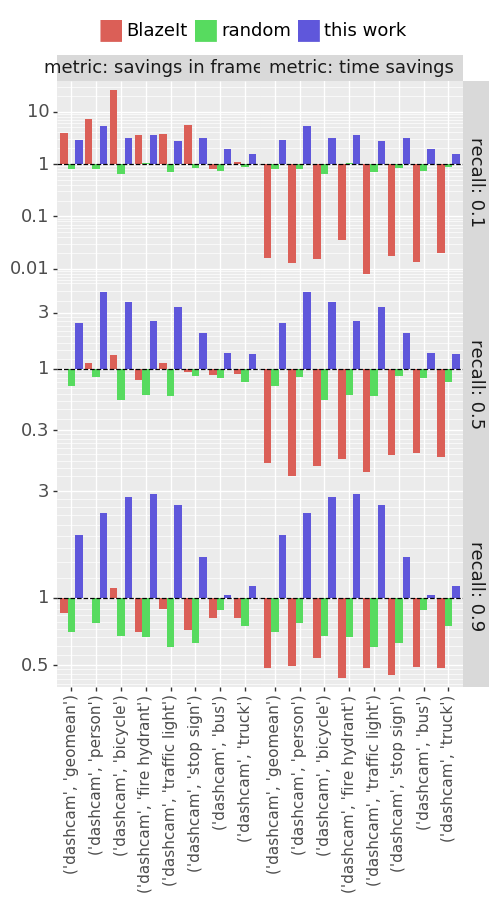

<ggplot: (8751109211084)>

<Figure size 432x288 with 0 Axes>

In [57]:
from plotnine.data import mtcars
from plotnine.themes import element_rect
import plotnine.scales


dodge_text = position_dodge(width=.2)

pt = (ggplot()
        + geom_bar(gms, 
                   aes(y='q5', x='order_key', fill='method', fill_alpha=.6),
                   stat='identity', position='dodge',
                   #fill='#095890', 
                   show_legend=True)
        + geom_hline(mapping=aes(yintercept=1.), data=pd.DataFrame({'hi':[1]}), linetype='dashed')
        + facet_grid(['recall', 'metric'], labeller='label_both', scales='free_y')
        + scale_y_log10()
        + plotnine.labels.ylab('')
        + plotnine.labels.xlab('')
        + theme(legend_title=element_text(color='#ffffff',size=1),
                legend_direction='horizontal',
                legend_position='top',
                strip_text=element_text(size=13),
                axis_text_x=element_text(size=11, angle=90, ha='center'), #  color='#ffffff',size=1.),
                axis_title_x=element_text(size=1, alpha=0),
                figure_size=(3.5*1.5,1.5*3.5*7.5/5),
                legend_margin=0,
                panel_spacing_x=0,
                panel_spacing_y=0,
                legend_box_margin=0,
                axis_text_y=element_text(size=13, ha='right'),
                legend_text=element_text(size=13),
               )

 )
display(pt)

mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':10})
mpl.rc('text', usetex=True)
params= {'text.latex.preamble' : [r'\usepackage{amsmath}']}


def to_frac(text):
    lab = text._text
    pars = fractions.Decimal(lab)
    myfr = fractions.Fraction.from_decimal(pars)
    
    if myfr.numerator == 0:
        return r'$0$'
    
    inv = 1/myfr
    approx = inv.limit_denominator(40)
    err = approx - inv
    if err.numerator != 0:
        rel_err = float(np.abs(err)/inv)
        if rel_err > .02:
            approx = inv

    if approx.denominator == 1:
        return r'$%d$' % (approx.numerator)
    else:
        return r'$\dfrac{%d}{%d}$' % (approx.numerator, approx.denominator)
        
#fmt = matplotlib.ticker.FuncFormatter(lambda )#Formatter(StrMethodFormatter("{x}")
mpl.pyplot.rcParams.update(params)
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})

import fractions
f = plt.gcf()
axes = f.get_axes()
for (i,ax) in enumerate(axes):
    xaxis = ax.xaxis
    xaxis.set_tick_params(size=0)
    if i < len(axes) - 2:
        ax.set_xticks([])
    ax.grid(False, axis='x')
    #ax.grid(False, which='minor', axis='y')
    (m,mx) = xaxis.get_data_interval()
    centers = np.arange(np.ceil(m), np.floor(mx)+1)
    for (i,c) in enumerate(centers):
        if i == 0:
            ax.axvspan(c-.5,c+.5, 
                   color='gray', 
                   alpha=.4, 
                   linewidth=2)
        else:
            ax.axvspan(c-.5,c+.5, 
                       color='gray', 
                       alpha=.2 if i % 2 == 0 else .0, 
                       linewidth=0)
f.subplots_adjust(hspace=.25, wspace=.14)

f = plt.gcf()
for a in f.axes:
#    a.xaxis.set_major_formatter(fmt)
    #a.yaxis.set_major_formatter(fmt)
    labs  = a.get_yticklabels()        
    labs2 = list(map(lambda x : x._text, labs))
    if len(labs2)>0:
        labs2[-1] = labs2[-1] + 'x'
    a.set_yticklabels(labs2)
    
    labsx  = a.get_xticklabels()
    def lb(tx):
        lx = tx._text.split("'")[-2]
        if lx == 'geomean':
            return lx #r'{\bf mean}'
        else:
            return lx
        
    labsx = map(lb, labsx)
    a.set_xticklabels(list(labsx))

    
f.savefig('/tmp/sigmod_savings_most_recent.pdf')

In [523]:
cdat = recall_cdat(bmerge)

In [527]:
cdat[(cdat.recall ==.1) & (cdat.object_class == 'bicycle')]

,baseline,dataset,method,metric,nf,object_class,recall,sampler_id,savings,total_time
0,267.957707,dashcam,BlazeIt,time savings,NaN,bicycle,0.1,1571164417645140,0.015458,17334.306066
1,267.957707,dashcam,random,time savings,NaN,bicycle,0.1,1571164675351647,0.644628,415.677981
2,267.957707,dashcam,random+,time savings,NaN,bicycle,0.1,1571164674367186,1.000000,267.957707
3,267.957707,dashcam,this work,time savings,NaN,bicycle,0.1,1571164679162830,3.120000,85.883880
0,3120.000000,dashcam,BlazeIt,savings in frames,120.0,bicycle,0.1,1571164417645140,26.000000,NaN
1,3120.000000,dashcam,random,savings in frames,4840.0,bicycle,0.1,1571164675351647,0.644628,NaN
2,3120.000000,dashcam,random+,savings in frames,3120.0,bicycle,0.1,1571164674367186,1.000000,NaN
3,3120.000000,dashcam,this work,savings in frames,1000.0,bicycle,0.1,1571164679162830,3.120000,NaN


In [480]:
mt = ms[ms.method == 'this work']
mt.q5.min(), mt.q5.max()

(0.4988136673686022, 3.8313170364967606)

<IPython.core.display.Javascript object>


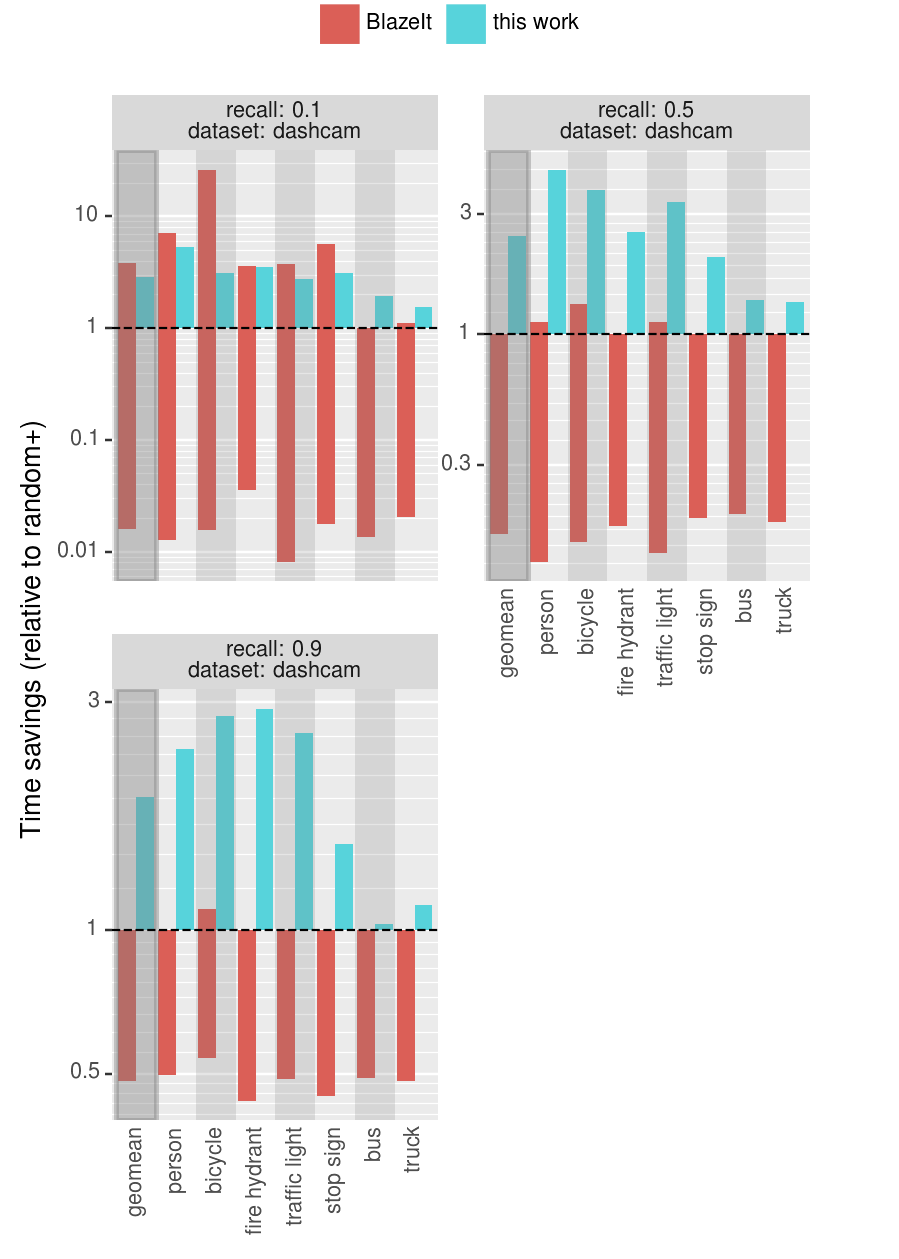

<ggplot: (8761824011889)>

In [481]:
from plotnine.data import mtcars
from plotnine.themes import element_rect
import plotnine.scales


#ms = ms[ms.method.isin(['this work'])]
dodge_text = position_dodge(width=.2)

pt = (ggplot()
        + geom_bar(gms, 
                   aes(y='q5', x='order_key', fill='method', fill_alpha=.6),
                   stat='identity', position='dodge',
                   #fill='#095890', 
                   show_legend=True)
        + geom_hline(mapping=aes(yintercept=1.), data=pd.DataFrame({'hi':[1]}), linetype='dashed')
        + facet_wrap(['recall', 'dataset'], ncol=2, labeller='label_context', scales='free')
        + scale_y_log10(name='Time savings (relative to random+)')
        + plotnine.labels.xlab('')
        + theme(legend_title=element_text(color='#ffffff'),
                legend_direction='horizontal',
                legend_position='top',
                axis_text_x=element_text(angle=90, ha='center',), #  color='#ffffff',size=1.),
                axis_title_x=element_text(size=1, alpha=0),
                figure_size=(5.,7.),
               )

 )
display(pt)

mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':10})
mpl.rc('text', usetex=True)
params= {'text.latex.preamble' : [r'\usepackage{amsmath}']}


def to_frac(text):
    lab = text._text
    pars = fractions.Decimal(lab)
    myfr = fractions.Fraction.from_decimal(pars)
    
    if myfr.numerator == 0:
        return r'$0$'
    
    inv = 1/myfr
    approx = inv.limit_denominator(40)
    err = approx - inv
    if err.numerator != 0:
        rel_err = float(np.abs(err)/inv)
        if rel_err > .02:
            approx = inv

    if approx.denominator == 1:
        return r'$%d$' % (approx.numerator)
    else:
        return r'$\dfrac{%d}{%d}$' % (approx.numerator, approx.denominator)
        
#fmt = matplotlib.ticker.FuncFormatter(lambda )#Formatter(StrMethodFormatter("{x}")
mpl.pyplot.rcParams.update(params)
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})

import fractions
f = plt.gcf()
axes = f.get_axes()
for (i,ax) in enumerate(axes):
    xaxis = ax.xaxis
    xaxis.set_tick_params(size=0)
    if i < len(axes) - 2:
        ax.set_xticks([])
    ax.grid(False, axis='x')
    #ax.grid(False, which='minor', axis='y')
    (m,mx) = xaxis.get_data_interval()
    centers = np.arange(np.ceil(m), np.floor(mx)+1)
    for (i,c) in enumerate(centers):
        if i == 0:
            ax.axvspan(c-.5,c+.5, 
                   color='gray', 
                   alpha=.4, 
                   linewidth=2)
        else:
            ax.axvspan(c-.5,c+.5, 
                       color='gray', 
                       alpha=.2 if i % 2 == 0 else .0, 
                       linewidth=0)
f.subplots_adjust(hspace=.25, wspace=.14)

f = plt.gcf()
for a in f.axes:
#    a.xaxis.set_major_formatter(fmt)
    #a.yaxis.set_major_formatter(fmt)
    labs  = a.get_yticklabels()        
    labs2 = map(to_frac, labs)
    labs2 = list(labs2)
    #a.set_yticklabels(labs2)
    
    labsx  = a.get_xticklabels()
    def lb(tx):
        lx = tx._text.split("'")[-2]
        if lx == 'geomean':
            return lx #r'{\bf mean}'
        else:
            return lx
        
    labsx = map(lb, labsx)
    a.set_xticklabels(list(labsx))

    
f.savefig('/tmp/sigmod_res_savings_time_most_recent.pdf')